# NDVI

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import rasterstats
import rasterio
from osgeo import gdal

from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
from rasterio.plot import show
import glob
import subprocess
import os
import pyproj

# Read LAD

In [3]:
polygon = gpd.read_file(r'./LAD/Local_Authority_Districts_(May_2021)_UK_BFE/LAD_MAY_2021_UK_BFE_V2.shp')

In [4]:
england = pd.read_excel('England_class.xlsx')

In [5]:
england_poly = pd.merge(england, polygon, left_on='LAD', right_on='LAD21CD', how='left')

In [6]:
england_poly_geo = gpd.GeoDataFrame(england_poly, crs="EPSG:27700", geometry=england_poly['geometry'])

In [7]:
print(england_poly_geo.crs)

EPSG:27700


In [8]:
proj_crs = pyproj.CRS.from_string('ESRI:54009')

In [9]:
england_poly_geo = england_poly_geo.to_crs(proj_crs)

In [10]:
print(england_poly_geo.crs)

ESRI:54009


# Read raster

In [24]:
files_to_mosaic = glob.glob('./VI/NDVI/*resample.tif')
files_to_mosaic

['./VI/NDVI/1_resample.tif',
 './VI/NDVI/2_resample.tif',
 './VI/NDVI/3_resample.tif',
 './VI/NDVI/4_resample.tif']

In [25]:
files_string = " ".join(files_to_mosaic)
print(files_string)

./VI/NDVI/1_resample.tif ./VI/NDVI/2_resample.tif ./VI/NDVI/3_resample.tif ./VI/NDVI/4_resample.tif


In [26]:
command = "gdal_merge.py -o ./VI/NDVI/EDVI_Mosaic.tif -of gtiff " + files_string
print(os.popen(command).read())

0...10...20...30...40...50...60...70...80...90...100 - done.



In [27]:
print(os.popen('ls ./VI/NDVI/').read())

1_resample.tif
2_resample.tif
3_resample.tif
4_resample.tif
EDVI_Mosaic.tif



In [28]:
NDVI = rasterio.open('./VI/NDVI/EDVI_Mosaic.tif', mode = 'r')

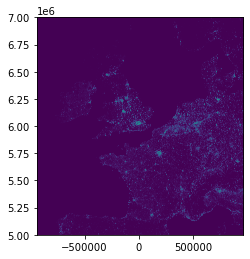

<AxesSubplot:>

In [29]:
show(NDVI)

# Assign raster values to a numpy array

In [30]:
edvi_array = NDVI.read(1)

In [31]:
edvi_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [32]:
NDVI.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 19000,
 'height': 20000,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(100.0, 0.0, -941000.0,
        0.0, -100.0, 7000000.0)}

In [33]:
affine = NDVI.transform

# calculating the zonal statistics

In [34]:
england_poly_geo = england_poly_geo[~(england_poly_geo['geometry'].is_empty | england_poly_geo['geometry'].isna())]

In [35]:
stats = rasterstats.zonal_stats(england_poly_geo, edvi_array, affine = affine, stats = ['mean'])

/opt/conda/envs/sds2021/lib/python3.9/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [36]:
df = pd.DataFrame(stats)

In [37]:
df = pd.concat([england_poly_geo, df], axis=1)

In [39]:
edvi = gpd.GeoDataFrame(df, geometry = df.geometry)
edvi.head()

,LAD,LAD_Name,Country,Region,County_Code,County_Name,OBJECTID,LAD21CD,LAD21NM,BNG_E,BNG_N,LONG,LAT,SHAPE_Leng,SHAPE_Area,geometry,mean
0,E06000001,Hartlepool,England,North East,E06000001,Hartlepool,1.0,E06000001,Hartlepool,447160.0,531474.0,-1.27018,54.676140,66110.011028,9.835107e+07,"POLYGON ((-90160.490 6359038.856, -90144.116 6...",10.175555
1,E06000002,Middlesbrough,England,North East,E06000002,Middlesbrough,2.0,E06000002,Middlesbrough,451141.0,516887.0,-1.21099,54.544670,41055.789790,5.455359e+07,"POLYGON ((-89115.357 6345480.407, -89002.190 6...",25.857615
2,E06000003,Redcar and Cleveland,England,North East,E06000003,Redcar and Cleveland,3.0,E06000003,Redcar and Cleveland,464361.0,519597.0,-1.00608,54.567520,105292.103526,2.537854e+08,"POLYGON ((-81203.904 6351144.074, -80985.739 6...",7.270170
3,E06000004,Stockton-on-Tees,England,North East,E06000004,Stockton-on-Tees,4.0,E06000004,Stockton-on-Tees,444940.0,518183.0,-1.30664,54.556911,108085.190140,2.097308e+08,"POLYGON ((-93750.320 6350849.264, -93740.521 6...",11.559444
4,E06000005,Darlington,England,North East,E06000005,Darlington,5.0,E06000005,Darlington,428029.0,515648.0,-1.56835,54.535339,107203.152334,1.974778e+08,"POLYGON ((-116603.223 6348061.713, -116603.622...",6.848018


In [41]:
edvi.to_csv(r'./OUTPUT/NDVI.csv')

<AxesSubplot:>

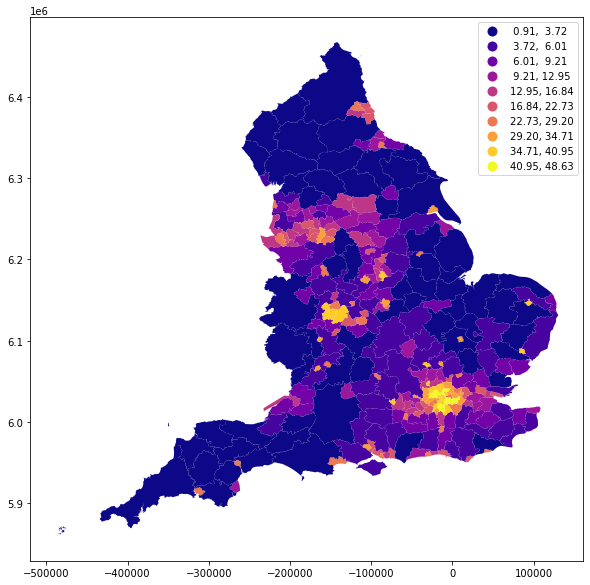

In [43]:
edvi.plot(column='mean', cmap='plasma', 
         scheme='FisherJenks', k=10, edgecolor='None', legend=True, figsize=(10,10))

# NDVI_2

In [65]:
NDVI = rasterio.open('./VI/NDVI_clip.tif', mode = 'r')

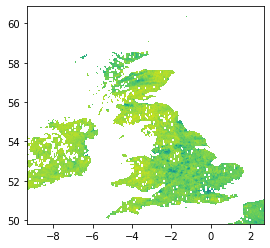

<AxesSubplot:>

In [67]:
show(NDVI)

In [69]:
england_poly_geo = england_poly_geo.to_crs('epsg:4326')

<AxesSubplot:title={'center':'built env'}>

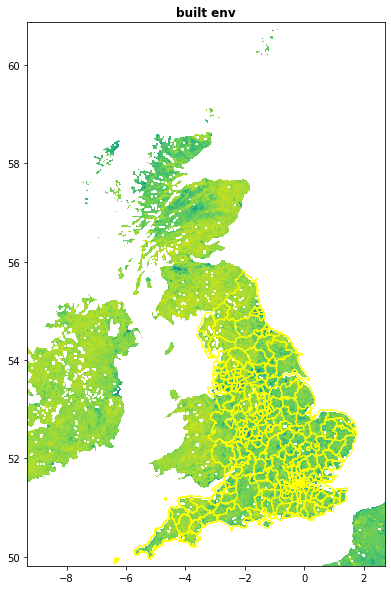

In [70]:
fig, ax = plt.subplots(1,1, figsize = (10, 10))
show(NDVI, ax = ax, title  = 'built env')
#show(raster_2, ax = ax, title  = 'raster_2')
#show(raster_3, ax = ax, title  = 'raster_3')
#show(raster_4, ax = ax, title  = 'raster_4')
england_poly_geo.plot(ax = ax, facecolor = 'None',
                     edgecolor = 'yellow')
#show_hist(raster_1, title = 'histogram', ax = ax2)
#plt.show()

In [71]:
NDVI_array = NDVI.read(1)

In [72]:
NDVI_array

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 181, 173, 167],
       [255, 255, 255, ..., 188, 182, 181],
       [255, 255, 255, ..., 186, 182, 182]], dtype=uint8)

In [73]:
NDVI.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 4044,
 'height': 3713,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0029761904762040103, 0.0, -9.334821427795333,
        0.0, -0.002976190476189799, 60.86755952381387)}

In [74]:
affine = NDVI.transform

In [75]:
england_poly_geo = england_poly_geo[~(england_poly_geo['geometry'].is_empty | england_poly_geo['geometry'].isna())]

In [76]:
stats = rasterstats.zonal_stats(england_poly_geo, NDVI_array, affine = affine, stats = ['mean'])

/opt/conda/envs/sds2021/lib/python3.9/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [77]:
df = pd.DataFrame(stats)

In [78]:
df = pd.concat([england_poly_geo, df], axis=1)

In [79]:
NDVI = gpd.GeoDataFrame(df, geometry = df.geometry)
NDVI.head()

,LAD,LAD_Name,Country,Region,County_Code,County_Name,OBJECTID,LAD21CD,LAD21NM,BNG_E,BNG_N,LONG,LAT,SHAPE_Leng,SHAPE_Area,geometry,mean
0,E06000001,Hartlepool,England,North East,E06000001,Hartlepool,1.0,E06000001,Hartlepool,447160.0,531474.0,-1.27018,54.676140,66110.011028,9.835107e+07,"POLYGON ((-1.26844 54.72611, -1.26821 54.72608...",177.983819
1,E06000002,Middlesbrough,England,North East,E06000002,Middlesbrough,2.0,E06000002,Middlesbrough,451141.0,516887.0,-1.21099,54.544670,41055.789790,5.455359e+07,"POLYGON ((-1.25111 54.59152, -1.24952 54.59150...",156.053738
2,E06000003,Redcar and Cleveland,England,North East,E06000003,Redcar and Cleveland,3.0,E06000003,Redcar and Cleveland,464361.0,519597.0,-1.00608,54.567520,105292.103526,2.537854e+08,"POLYGON ((-1.14104 54.64772, -1.13796 54.64736...",187.692288
3,E06000004,Stockton-on-Tees,England,North East,E06000004,Stockton-on-Tees,4.0,E06000004,Stockton-on-Tees,444940.0,518183.0,-1.30664,54.556911,108085.190140,2.097308e+08,"POLYGON ((-1.31727 54.64479, -1.31713 54.64479...",180.405167
4,E06000005,Darlington,England,North East,E06000005,Darlington,5.0,E06000005,Darlington,428029.0,515648.0,-1.56835,54.535339,107203.152334,1.974778e+08,"POLYGON ((-1.63767 54.61713, -1.63766 54.61669...",189.429308


<AxesSubplot:>

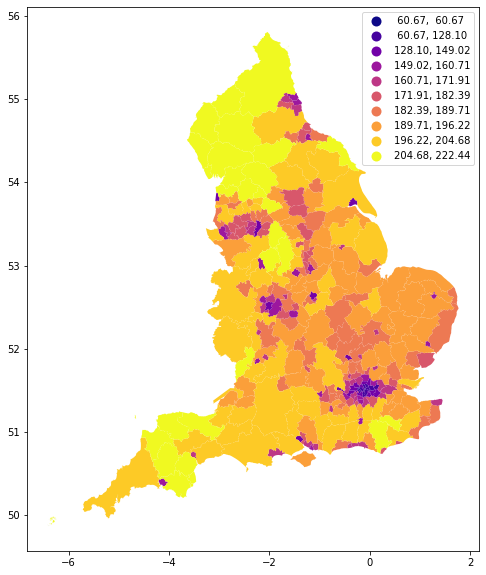

In [80]:
NDVI.plot(column='mean', cmap='plasma', 
         scheme='FisherJenks', k=10, edgecolor='None', legend=True, figsize=(10,10))

In [81]:
NDVI.to_csv(r'./OUTPUT/NDVI.csv')